<h1 style="color:rgb(81,183,206);font-size:2.5em;">Skillconnect - Week 2 - Advanced Challenge 1</h1>

**Learn to develop your own architecture for image classification task**

# Getting the data
Using CIFAR 10 

In [0]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [2]:
cifar_10 = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [3]:
train_all, test = cifar_10
X_train_all,y_train_all = train_all
X_test, y_test = test
X_train,X_valid,y_train,y_valid = train_test_split(X_train_all,y_train_all,train_size=0.9,stratify=y_train_all)

class_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
    'ship', 'truck'
]

sets = ['tr','va','te']
TR,VA,TE = sets

# Scale images from 0 to 1
X = {s:d.copy()/255 for s,d in zip(sets,[X_train,X_valid,X_test])}
y = {s:d.copy().squeeze() for s,d in zip(sets,[y_train,y_valid,y_test])}


print(X_train.shape,y_train.shape,X_valid.shape,y_valid.shape,X_test.shape,y_test.shape)

(45000, 32, 32, 3) (45000, 1) (5000, 32, 32, 3) (5000, 1) (10000, 32, 32, 3) (10000, 1)


**View the data**

In [0]:
import numpy as np
import matplotlib.pyplot as plt

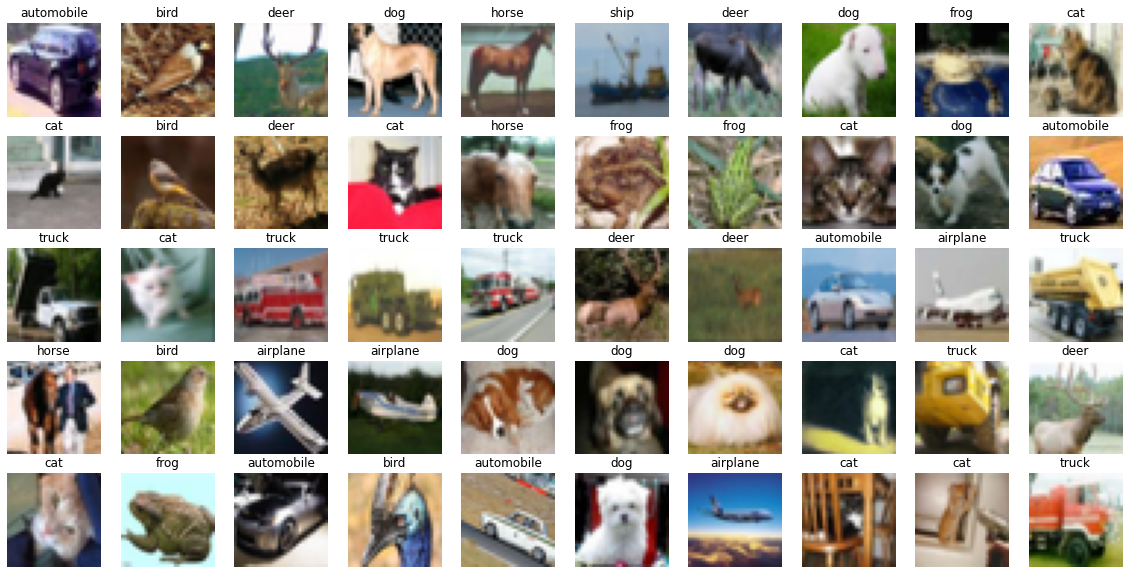

In [5]:
r,c = 5,10
plt.figure(figsize=(20,10))

r_idx = np.random.randint(0,len(y_train),(r*c,))
for i in range(r*c):
    idx = r_idx[i]
    label = class_labels[y_train[idx].item()]
    plt.subplot(r,c,i+1)
    plt.imshow(X_train[idx])
    plt.axis('off')
    plt.title(label)
plt.show() 

# Create Dataset and Dataloader
For use with pytorch

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [0]:
tf_ = lambda d: torch.tensor(d, dtype=torch.float32)
ti_ = lambda d: torch.tensor(d, dtype=torch.long)

micro_tr = 256
micro_va = 128

dl_micro_tr = DataLoader(TensorDataset(tf_(X[TR][:micro_tr].transpose(0,3,1,2)), ti_(y[TR][:micro_tr])),batch_size=64,shuffle=True)
dl_micro_va = DataLoader(TensorDataset(tf_(X[VA][:micro_va].transpose(0,3,1,2)), ti_(y[VA][:micro_va])),batch_size=64,shuffle=True)

dl = {s: DataLoader(TensorDataset(tf_(X[s].transpose(0,3,1,2)), ti_(y[s])),batch_size=64,shuffle=True) for s in sets}
dl_micro = {TR: dl_micro_tr, VA: dl_micro_va}

___

# Define a network

## Pytorch Implementation

In [0]:
import time
from copy import deepcopy

from torch import nn
from torchsummary import summary

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())

Tesla K80
(3, 7)


### Model Definition

In [0]:
class BasicConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride,padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class Stem(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = BasicConv(3, 32, 7)
        self.maxp1 = nn.MaxPool2d(3, 1)
        self.conv2 = BasicConv(32, 96, 1)
        self.conv3 = BasicConv(96, 192, 3)
        self.maxp2 = nn.MaxPool2d(3, 1)

    def forward(self, x):
        x = self.conv1(x)  # (32,26,26)
        x = self.maxp1(x)  # (32,24,24)
        x = self.conv2(x)  # (96,24,24)
        x = self.conv3(x)  # (192,22,22)
        x = self.maxp2(x)  # (192,20,20)
        return x
    
class IncepSkipBlock(nn.Module):
    def __init__(self, in_channel, out_channels):
        super().__init__()
        self.branch0 = BasicConv(in_channel, out_channels[0], 1)

        self.branch1 = nn.Sequential(
            BasicConv(in_channel, out_channels[1], 1,padding=1),
            BasicConv(out_channels[1], out_channels[3], 3)
        )

        self.branch2 = nn.Sequential(
            BasicConv(in_channel, out_channels[2], 1, padding=2),
            BasicConv(out_channels[2], out_channels[4], 5)
        )

        self.branch3 = nn.Sequential(
            nn.MaxPool2d(3, 1,padding=1),
            BasicConv(in_channel, out_channels[5], 1)
        )

    def forward(self, x):
        x_0 = self.branch0(x)
        x_1 = self.branch1(x)
        x_2 = self.branch2(x)
        x_3 = self.branch3(x)
        x = torch.cat([x,x_0,x_1,x_2,x_3],dim=1)
        return x
        
class LameNet(nn.Module):
    def __init__(self,classes=10):
        super().__init__()
        self.stem = Stem()
        self.block1 = IncepSkipBlock(192,[32,64,16,96,32,32])
        self.pblock1 = nn.Sequential(
            BasicConv(384,256,1),
            nn.MaxPool2d(3,2)
        )
        self.drop_1 = nn.Dropout2d(p=0.8)
        self.block2 = IncepSkipBlock(256,[64,128,32,192,64,64])
        self.pblock2 = nn.Sequential(
            BasicConv(640,512,1),
            nn.MaxPool2d(3,2)
        )
        self.conv3_1 = BasicConv(512,1024,3,1)
        self.drop_2 = nn.Dropout2d(p=0.6)
        self
        self.linear = nn.Linear(4096,classes)
        self.logits = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.pblock1(x)
        x = self.drop_1(x)
        x = self.block2(x)
        x = self.pblock2(x)
        x = self.conv3_1(x)
        x = self.drop_2(x)
        x = self.linear(x.view(x.size(0),-1))
        # x = self.logits(x)
        return x

### Helper Functions

#### Function to check accuracy

In [0]:
def check_accu(model, dl_test, verbose=True):
    model = model.to(device)
    model.eval()
    
    bs = dl_test.batch_size
    size = len(dl_test.dataset)
    batch_count = size//bs
    
    corrects = 0
    losses = 0
    percent = 0
    if verbose:
        print(f"batches ({batch_count}): ",end="\n\t")
    for i,batch in enumerate(dl_test):
        with torch.no_grad():
            X,y = batch
            if verbose:
                print(str(i).rjust(len(str(batch_count))+1),end="")
                if ((i+1) % 25) == 0:
                    print(end="\n\t")

            b = len(y)
            X = X.to(device)
            y = y.to(device)
            y_ = model(X)

            losses += loss_func(y_,y).item() * b
            corrects += (y_.argmax(dim=1)==y).sum().item()
    loss, accu = losses/size, corrects/size
    if verbose:
        print(f"\nloss: {loss:0.4f} accuracy: {accu:0.4f}")
    return loss, accu

#### Fit Function

In [0]:
def fit(model, optim, sched, loss_func, dl, epochs=1, is_test=False):
    model = model.to(device)

    # Test batch multipliers
    tb_t,tb_v = 6,2

    # To switch between training and validation
    phases = [TR, VA]

    # Measure total time
    tot_time = time.time()

    # Record metrics
    losses = {TR:[], VA:[]}
    accuracies = {TR:[], VA:[]}

    # Dataset sizes for accu and loss calcualtions
    sizes = {ph: len(dl[ph].dataset) for ph in phases}
    if is_test:
        sizes[TR] = tb_t * dl[TR].batch_size
        sizes[VA] = tb_v * dl[VA].batch_size
    
    # Init markers
    least_loss = float('inf')
    best_accu = 0
    best_model = deepcopy(model.state_dict())
    
    for e in range(epochs):
        # Measure the epoch time (train + valid)
        epo_time = time.time()

        # Print epoch counter
        epoch_st = f"[{e+1}/{epochs}]".rjust(len(str(epochs))*2+3)
        print(f"{epoch_st} | ",end="")
        
        for phase in phases:
            # Running metrics, caluclate as they come in
            running_loss = 0
            running_corr = 0

            # bool checker used ahead for updating markers and optimizer step
            is_tr = phase == TR

            # Iterate over training or validation batch
            for b_num,batch in enumerate(dl[phase]):

                # Limit batches if testing fit function
                if is_test:
                    if is_tr:
                        if b_num == tb_t:
                            break
                    elif not is_tr and b_num == tb_v:
                        break
                    else:
                        pass

                # Get data and batch size
                X,y = batch
                bs = y.size(0)
                
                # Shift data to device (when GPU)
                X = X.to(device)
                y = y.to(device)
                    
                # Reset gradients to zero
                optim.zero_grad()
                
                # Sets model.eval or model.train depending on bool
                with torch.set_grad_enabled(is_tr):

                    # Forward pass 
                    y_pred = model(X)

                    # Calculate loss using loss_function 
                    loss = loss_func(y_pred,y)

                    # Update weights only if trianing phase
                    if is_tr:
                        loss.backward()
                        optim.step()
                        
                    # Update lr if validation loss don't change none
                    if not is_tr:
                        sched.step(loss)
                
                # Deaverage the loss and get correct predictions
                batch_loss = loss.item() * bs
                batch_corr = (y_pred.argmax(dim=1) == y).sum().item()
                # Add to running metrics
                running_loss += batch_loss
                running_corr += batch_corr

            # Calculate epochal loss and accu
            epo_loss = running_loss / sizes[phase]
            epo_accu = running_corr / sizes[phase]
            
            # Print epochal metrics
            print(f"{phase} :: loss: {epo_loss:0.4f} accu: {epo_accu:0.4f} | ", end="")
            
            # Store metrics
            losses[phase].append(epo_loss)
            accuracies[phase].append(epo_accu)
            
            # Update markers if not training
            if not is_tr:
                if epo_accu > best_accu:
                    best_accu = epo_accu
            
                if epo_loss < least_loss:
                    least_loss = epo_loss
                    best_model = deepcopy(model.state_dict())
            
        # Print time taken by epoch
        end_time = np.round(time.time() - epo_time,3)
        s,ms = str(end_time).split('.')
        print(f"time {s} s {ms} ms")

    # Restore "best" model, print total time and metrics.
    model.load_state_dict(best_model)
    end_time = np.round(time.time() - tot_time,3)
    s,ms = str(end_time).split('.')
    print(f"best accuracy: {best_accu:0.4f} least loss: {least_loss:0.4f}")
    print(f"time {int(s)//60} m {int(s)%60} s {ms} ms")

    return losses, accuracies

#### Optimal Learning Rate Finding Helpers

In [0]:
def simple_fit(model,dl,optim,loss_func,epoch=10):
    model = model.to(device)
    losses = []
    for e in range(epoch):
        r_loss = 0
        for X,y in dl:
            bs = y.size(0)
            X = X.to(device)
            y = y.to(device)

            optim.zero_grad()
            y_ = model(X)
            loss = loss_func(y_,y)
            loss.backward()
            optim.step()
            r_loss += loss.item() * bs
        losses.append(r_loss/len(dl.dataset))
    return losses

def net_tester(Model,dl,test_epochs,lr_list):
    losses_list = []
    metric_list = []
    for lr in lr_list:
        model = Model()
        loss_func = torch.nn.CrossEntropyLoss()
        optim = torch.optim.Adam(model.parameters(),lr=lr)

        # Obtain the metrics
        losses_ = simple_fit(model,dl,optim,loss_func,epoch=100)
        loss_, accu_ = check_accu(model,dl,False)

        # Store the metrics
        losses_list.append(losses_)
        metric_list.append((loss_,accu_))

        # Disply the metrics
        print(f"lr: {lr}\tloss: {loss_}   accu: {accu_}")
        plt.figure(figsize=(10,5))
        plt.grid(True)
        plt.plot(np.arange(len(losses_)),losses_)
        plt.show()
    return losses_list, metric_list

lr: 0.01	loss: 2.2263333797454834   accu: 0.234375


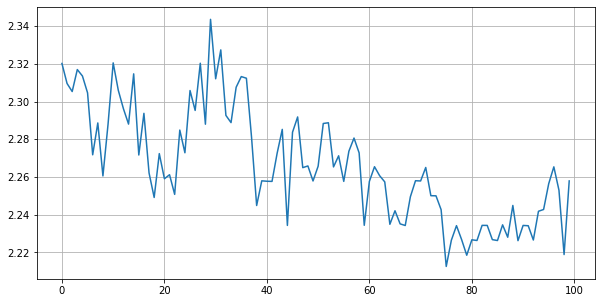

lr: 0.001	loss: 1.7172525525093079   accu: 0.75


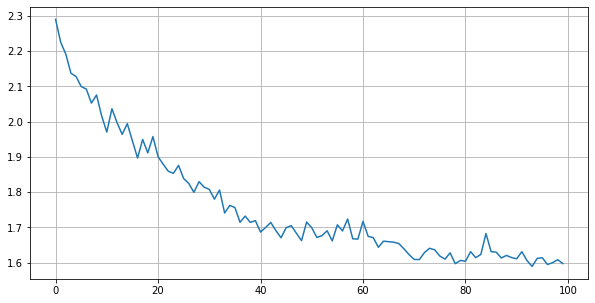

lr: 0.0005	loss: 1.824423611164093   accu: 0.640625


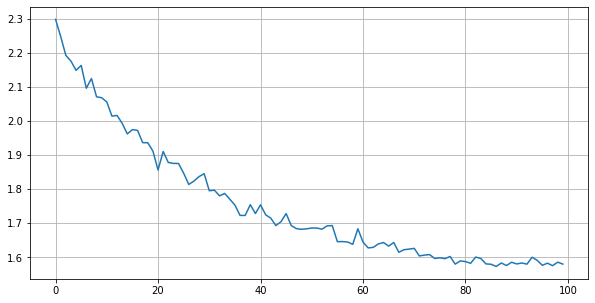

lr: 0.0001	loss: 2.0863739252090454   accu: 0.3359375


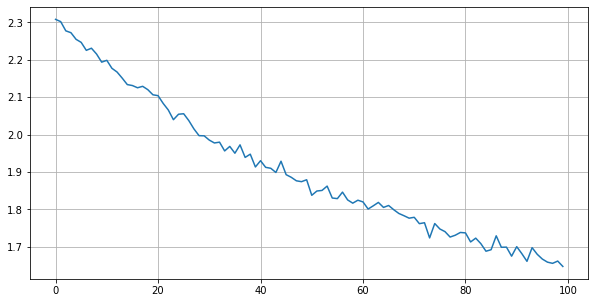

lr: 0.0004	loss: 1.6813330054283142   accu: 0.7890625


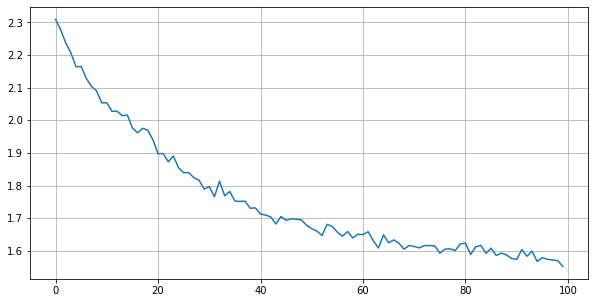

lr: 5e-05	loss: 2.1266603469848633   accu: 0.3515625


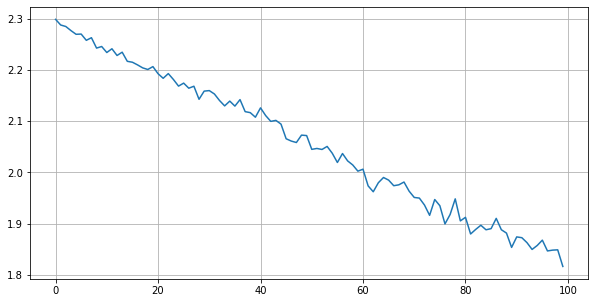

lr: 1e-05	loss: 2.2672135829925537   accu: 0.1484375


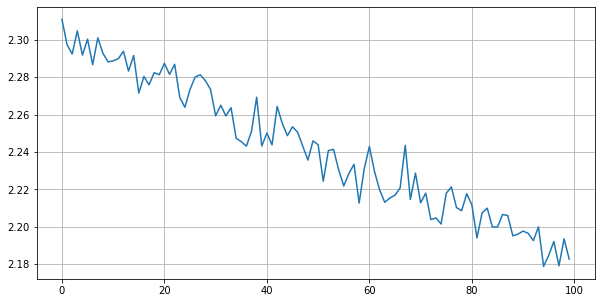

In [24]:
learning_rates = [0.01,0.001,0.0005,0.0001,4e-4, 0.00005,0.00001]
losses_list, metric_list = net_tester(LameNet, dl_micro[TR], 200,learning_rates)

### Fit
*Test run*

In [86]:
model_pt = LameNet()
loss_func = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_pt.parameters(),lr=1e-3,weight_decay=1e-4)
# sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, threshold=5e-5, patience=10)
sched = torch.optim.lr_scheduler.StepLR(optim, 10, 0.5)

_ = fit(model_pt, optim, sched, loss_func, dl_micro, epochs=30)

 [1/30] | tr :: loss: 2.6655 accu: 0.1133 | va :: loss: 2.6507 accu: 0.1406 | time 0 s 649 ms
 [2/30] | tr :: loss: 2.3343 accu: 0.2383 | va :: loss: 2.5217 accu: 0.2266 | time 0 s 611 ms
 [3/30] | tr :: loss: 2.1627 accu: 0.2383 | va :: loss: 2.5251 accu: 0.1641 | time 0 s 595 ms
 [4/30] | tr :: loss: 2.0826 accu: 0.2539 | va :: loss: 2.5201 accu: 0.1719 | time 0 s 611 ms
 [5/30] | tr :: loss: 1.9634 accu: 0.3281 | va :: loss: 2.6472 accu: 0.1797 | time 0 s 601 ms
 [6/30] | tr :: loss: 1.8741 accu: 0.3320 | va :: loss: 2.5108 accu: 0.1641 | time 0 s 609 ms
 [7/30] | tr :: loss: 1.8208 accu: 0.3398 | va :: loss: 2.5116 accu: 0.1641 | time 0 s 596 ms
 [8/30] | tr :: loss: 1.5652 accu: 0.4531 | va :: loss: 2.3722 accu: 0.2188 | time 0 s 61 ms
 [9/30] | tr :: loss: 1.6095 accu: 0.4102 | va :: loss: 2.6460 accu: 0.2266 | time 0 s 612 ms
[10/30] | tr :: loss: 1.5118 accu: 0.4375 | va :: loss: 2.5249 accu: 0.2266 | time 0 s 594 ms
[11/30] | tr :: loss: 1.4877 accu: 0.4766 | va :: loss: 2.522

*Actual run*

In [87]:
losses, accuracies = fit(model_pt, optim, sched, loss_func, dl, epochs=10, is_test=False)

 [1/10] | tr :: loss: 1.8966 accu: 0.3693 | va :: loss: 1.7953 accu: 0.4504 | time 94 s 243 ms
 [2/10] | tr :: loss: 1.5591 accu: 0.4820 | va :: loss: 1.4291 accu: 0.5080 | time 93 s 972 ms
 [3/10] | tr :: loss: 1.3385 accu: 0.5419 | va :: loss: 1.2991 accu: 0.5462 | time 93 s 697 ms
 [4/10] | tr :: loss: 1.2152 accu: 0.5762 | va :: loss: 1.1613 accu: 0.6002 | time 94 s 154 ms
 [5/10] | tr :: loss: 1.1088 accu: 0.6133 | va :: loss: 1.1102 accu: 0.6160 | time 94 s 248 ms
 [6/10] | tr :: loss: 1.0567 accu: 0.6315 | va :: loss: 1.0285 accu: 0.6380 | time 94 s 088 ms
 [7/10] | tr :: loss: 1.0060 accu: 0.6498 | va :: loss: 1.0050 accu: 0.6592 | time 94 s 25 ms
 [8/10] | tr :: loss: 0.9531 accu: 0.6667 | va :: loss: 1.0272 accu: 0.6408 | time 94 s 302 ms
 [9/10] | tr :: loss: 0.9243 accu: 0.6791 | va :: loss: 0.9867 accu: 0.6606 | time 94 s 089 ms
[10/10] | tr :: loss: 0.8911 accu: 0.6893 | va :: loss: 0.9239 accu: 0.6844 | time 94 s 689 ms
best accuracy: 0.6844 least loss: 0.9239
time 15 m 

In [88]:
losses, accuracies = fit(model_pt, optim, sched, loss_func, dl, epochs=20, is_test=False)

 [1/20] | tr :: loss: 0.8576 accu: 0.7027 | va :: loss: 0.9461 accu: 0.6768 | time 94 s 993 ms
 [2/20] | tr :: loss: 0.8213 accu: 0.7153 | va :: loss: 0.8773 accu: 0.6970 | time 94 s 644 ms
 [3/20] | tr :: loss: 0.7902 accu: 0.7243 | va :: loss: 0.8665 accu: 0.7036 | time 94 s 468 ms
 [4/20] | tr :: loss: 0.7624 accu: 0.7328 | va :: loss: 0.8537 accu: 0.7076 | time 94 s 853 ms
 [5/20] | tr :: loss: 0.7426 accu: 0.7408 | va :: loss: 0.8364 accu: 0.7172 | time 94 s 541 ms
 [6/20] | tr :: loss: 0.7235 accu: 0.7477 | va :: loss: 0.8296 accu: 0.7124 | time 94 s 238 ms
 [7/20] | tr :: loss: 0.6979 accu: 0.7571 | va :: loss: 0.8054 accu: 0.7290 | time 94 s 465 ms
 [8/20] | tr :: loss: 0.6632 accu: 0.7693 | va :: loss: 0.8614 accu: 0.7134 | time 94 s 424 ms
 [9/20] | tr :: loss: 0.6507 accu: 0.7738 | va :: loss: 0.7998 accu: 0.7322 | time 94 s 625 ms
[10/20] | tr :: loss: 0.6284 accu: 0.7821 | va :: loss: 0.8202 accu: 0.7208 | time 94 s 558 ms
[11/20] | tr :: loss: 0.6162 accu: 0.7865 | va :: 

### Test

In [90]:
check_accu(model_pt, dl[TE])

batches (156): 
	   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24
	  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
	  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
	  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
	 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
	 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
	 150 151 152 153 154 155 156
loss: 0.6769 accuracy: 0.7782


(0.6769017164230346, 0.7782)

___

## Keras Implementation

In [0]:
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers, activations, optimizers, losses, callbacks

In [94]:
print((tf.version.VERSION))
print(tf.config.list_physical_devices('GPU'))

2.2.0-rc3
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Model Definition

In [0]:
def basic_conv(name, out_channels, kernel_size, stride=1, padding='valid'):
    return keras.Sequential([
        layers.Conv2D(out_channels,kernel_size, stride,padding,activation=None),
        layers.BatchNormalization(),
        layers.ReLU()
    ],name)

def stem():
    return keras.Sequential([
        basic_conv("conv_7_1",32,7),
        layers.MaxPool2D((3,3),1),
        basic_conv("conv_1_1",96,1),
        basic_conv("conv_3_1",192,3),
        layers.MaxPool2D((3,3),1)
    ],name="stem")

def incep_skip_block(input_shape, out_channels, name):
    branch0 = basic_conv("conv_1_1",out_channels[0],1)
    branch1 = keras.Sequential([
        basic_conv("conv_1_2",out_channels[1],1),
        basic_conv("conv_1_2",out_channels[3],3, padding='same')
        
    ])
    branch2 = keras.Sequential([
        basic_conv("conv_1_2",out_channels[2],1),
        basic_conv("conv_1_2",out_channels[4],5, padding='same')
    ])
    branch3 = keras.Sequential([
        layers.MaxPool2D((3,3),strides=1,padding='same'),
        basic_conv("conv_1_2",out_channels[5],1)
    ])
    input_ = layers.Input(shape=input_shape)
    b0_out = branch0(input_)
    b1_out = branch1(input_)
    b2_out = branch2(input_)
    b3_out = branch3(input_)
    output_ = layers.concatenate([input_,b0_out,b1_out,b2_out,b3_out])
    return keras.Model(inputs=[input_],outputs=[output_],name=name)

def post_block(out_channels,name):
    return keras.Sequential([
        basic_conv("conv_1_1",out_channels,1),
        layers.MaxPool2D((3,3),2)
    ],name)

def lame_net(classes=10,name="lame_net"):
    input_ = layers.Input(shape=(32,32,3))
    stem_ = stem()(input_)
    
    isblock1 = incep_skip_block((20,20,192),[32,64,16,96,32,32],'incep_skip_1')(stem_)
    pblock1 = post_block(256,'pblock_1')(isblock1)
    
    dropout_1 = layers.Dropout(rate=0.2)(pblock1)

    isblock2 = incep_skip_block((9,9,256),[64,128,32,192,64,64],'incep_skip_2')(dropout_1)
    pblock2 = post_block(512,'pblock_2')(isblock2)
    
    conv3_1 = basic_conv("conv_3_1",1024,3)(pblock2)
    dropout_2 = layers.Dropout(rate=0.4,)(conv3_1)

    flatten = layers.Flatten()(dropout_2)
    softmax = layers.Dense(10,activation='softmax',kernel_regularizer=keras.regularizers.l2(0.0001))(flatten)
    return keras.Model(inputs=[input_],outputs=[softmax],name=name)

In [96]:
model_ke = lame_net(10,"lame_net")
model_ke.summary()

Model: "lame_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
stem (Sequential)            (None, 20, 20, 192)       175264    
_________________________________________________________________
incep_skip_1 (Model)         (None, 20, 20, 384)       97104     
_________________________________________________________________
pblock_1 (Sequential)        (None, 9, 9, 256)         99584     
_________________________________________________________________
dropout_4 (Dropout)          (None, 9, 9, 256)         0         
_________________________________________________________________
incep_skip_2 (Model)         (None, 9, 9, 640)         348832    
_________________________________________________________________
pblock_2 (Sequential)        (None, 4, 4, 512)         330

**Compile the model**

In [0]:
model_ke.compile(
    optimizer=optimizers.Adam(learning_rate=4e-4),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

**Ready the data (alter shapes for keras)**

In [0]:
X_for_keras = lambda X:X.transpose(0,1,2,3)
y_for_keras = lambda y:y.squeeze()

X_ke = {s: X_for_keras(X[s]) for s in sets}
y_ke = {s: y_for_keras(y[s]) for s in sets}

**Callbacks**

In [0]:
lr_scheduler_cb = callbacks.ReduceLROnPlateau(factor=0.5, min_delta=5e-5, patience=5)
early_stopping_cb = callbacks.EarlyStopping(min_delta=0.01,patience=20,restore_best_weights=True)

**Fit**  

*test run just an epoch*

In [100]:
_ = model_ke.fit(x=X_ke[TR][:micro_tr],
                 y=y_ke[TR][:micro_tr],
                 validation_data=(X_ke[VA][:micro_va], y_ke[VA][:micro_va]),
                 batch_size=64,
                 epochs=9,
                 callbacks = [lr_scheduler_cb, early_stopping_cb])

Epoch 1/9
4/4 [==============================] - 1s 240ms/step - loss: 2.8051 - accuracy: 0.1562 - val_loss: 2.2920 - val_accuracy: 0.1641 - lr: 4.0000e-04
Epoch 2/9
4/4 [==============================] - 0s 106ms/step - loss: 1.2919 - accuracy: 0.5156 - val_loss: 2.3225 - val_accuracy: 0.0938 - lr: 4.0000e-04
Epoch 3/9
4/4 [==============================] - 0s 108ms/step - loss: 0.8322 - accuracy: 0.7305 - val_loss: 2.3893 - val_accuracy: 0.0781 - lr: 4.0000e-04
Epoch 4/9
4/4 [==============================] - 0s 105ms/step - loss: 0.5499 - accuracy: 0.8320 - val_loss: 2.4859 - val_accuracy: 0.0625 - lr: 4.0000e-04
Epoch 5/9
4/4 [==============================] - 0s 111ms/step - loss: 0.2876 - accuracy: 0.9336 - val_loss: 2.5752 - val_accuracy: 0.0625 - lr: 4.0000e-04
Epoch 6/9
4/4 [==============================] - 0s 105ms/step - loss: 0.2064 - accuracy: 0.9570 - val_loss: 2.6917 - val_accuracy: 0.0625 - lr: 4.0000e-04
Epoch 7/9
4/4 [==============================] - 0s 105ms/step -

*actual fit*

In [101]:
history = model_ke.fit(x=X_ke[TR],
                       y=y_ke[TR],
                       validation_data=(X_ke[VA], y_ke[VA]),
                       batch_size=64,
                       epochs=40,
                       callbacks=[lr_scheduler_cb, early_stopping_cb])

Epoch 1/40
704/704 [==============================] - 80s 114ms/step - loss: 1.4897 - accuracy: 0.4959 - val_loss: 1.5854 - val_accuracy: 0.4708 - lr: 2.0000e-04
Epoch 2/40
704/704 [==============================] - 79s 112ms/step - loss: 1.0861 - accuracy: 0.6241 - val_loss: 1.3182 - val_accuracy: 0.5658 - lr: 2.0000e-04
Epoch 3/40
704/704 [==============================] - 79s 112ms/step - loss: 0.8956 - accuracy: 0.6884 - val_loss: 1.3490 - val_accuracy: 0.5738 - lr: 2.0000e-04
Epoch 4/40
704/704 [==============================] - 79s 112ms/step - loss: 0.7665 - accuracy: 0.7341 - val_loss: 1.1408 - val_accuracy: 0.6118 - lr: 2.0000e-04
Epoch 5/40
704/704 [==============================] - 79s 112ms/step - loss: 0.6691 - accuracy: 0.7689 - val_loss: 1.0262 - val_accuracy: 0.6526 - lr: 2.0000e-04
Epoch 6/40
704/704 [==============================] - 79s 112ms/step - loss: 0.5882 - accuracy: 0.7949 - val_loss: 1.1055 - val_accuracy: 0.6524 - lr: 2.0000e-04
Epoch 7/40
704/704 [========

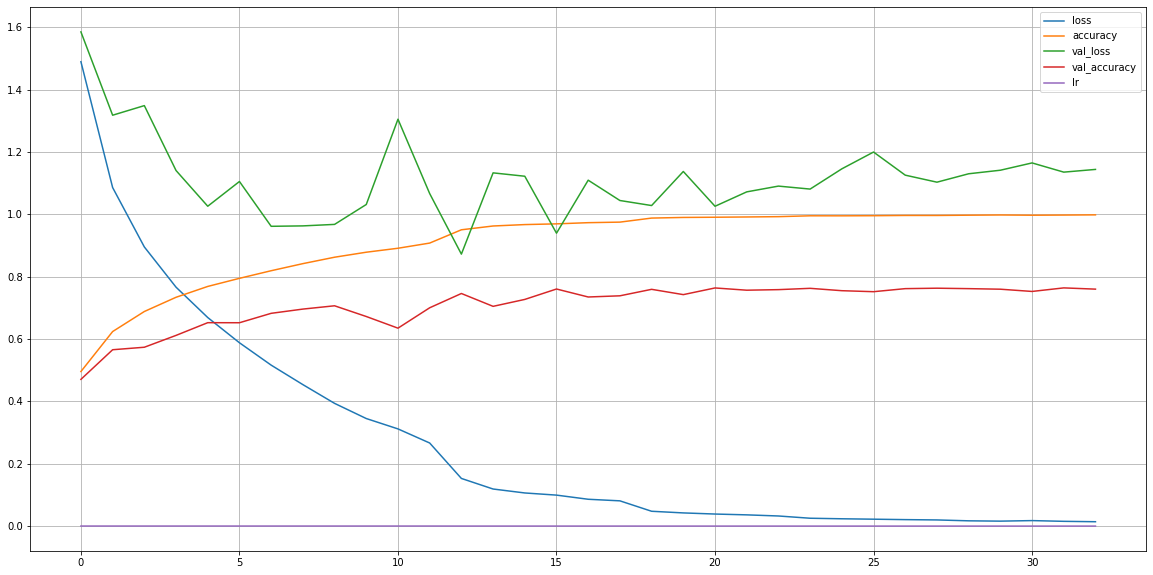

In [102]:
pd.DataFrame(history.history).plot(figsize=(20, 10))
plt.grid(True)
plt.show()

**Testing the model**

In [103]:
te_loss,te_accuracy = model_ke.evaluate(x=X_ke[TE],y=y_ke[TE],batch_size=64,verbose=0)
print(f"testing → loss: {te_loss:0.4f}  accuracy: {te_accuracy:0.4f}")

testing → loss: 0.8769  accuracy: 0.7461
